In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats


Read in data

In [3]:
df = pd.read_stata("karlan_list_2007.dta")
df.columns

Index(['treatment', 'control', 'ratio', 'ratio2', 'ratio3', 'size', 'size25',
       'size50', 'size100', 'sizeno', 'ask', 'askd1', 'askd2', 'askd3', 'ask1',
       'ask2', 'ask3', 'amount', 'gave', 'amountchange', 'hpa', 'ltmedmra',
       'freq', 'years', 'year5', 'mrm2', 'dormant', 'female', 'couple',
       'state50one', 'nonlit', 'cases', 'statecnt', 'stateresponse',
       'stateresponset', 'stateresponsec', 'stateresponsetminc', 'perbush',
       'close25', 'red0', 'blue0', 'redcty', 'bluecty', 'pwhite', 'pblack',
       'page18_39', 'ave_hh_sz', 'median_hhincome', 'powner', 'psch_atlstba',
       'pop_propurban'],
      dtype='object')

Balance Test

In [4]:
variables = ['mrm2', 'hpa', 'freq']  # you can add more

results = []

def t_test_formula(x_treat, x_control):
    # T-test using pooled standard error
    mean1, mean2 = np.mean(x_treat), np.mean(x_control)
    std1, std2 = np.std(x_treat, ddof=1), np.std(x_control, ddof=1)
    n1, n2 = len(x_treat), len(x_control)
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    t_stat = (mean1 - mean2) / se
    return t_stat, mean1 - mean2

for var in variables:
    treat_group = df[df['treatment'] == 1][var].dropna()
    control_group = df[df['treatment'] == 0][var].dropna()

    # --- T-test
    t_stat, t_diff = t_test_formula(treat_group, control_group)

    # --- Linear regression
    X = sm.add_constant(df['treatment'])
    y = df[var]
    model = sm.OLS(y, X).fit()
    reg_coef = model.params['treatment']
    reg_se = model.bse['treatment']
    reg_tstat = model.tvalues['treatment']

    results.append({
        'Variable': var,
        'T-test statistic': round(t_stat, 4),
        'Mean Diff (T-test)': round(t_diff, 4),
        'Regression Coef': round(reg_coef, 4),
        'T-stat (Regression)': round(reg_tstat, 4),
        'Match?': 'Yes' if np.isclose(t_stat, reg_tstat, atol=1e-4) else 'No'
    })

results_df = pd.DataFrame(results)
results_df


,Variable,T-test statistic,Mean Diff (T-test),Regression Coef,T-stat (Regression),Match?
0,mrm2,0.1195,0.0137,NaN,NaN,No
1,hpa,0.9704,0.6371,0.6371,0.9441,No
2,freq,-0.1108,-0.0120,-0.0120,-0.1109,Yes


In [5]:
# Second

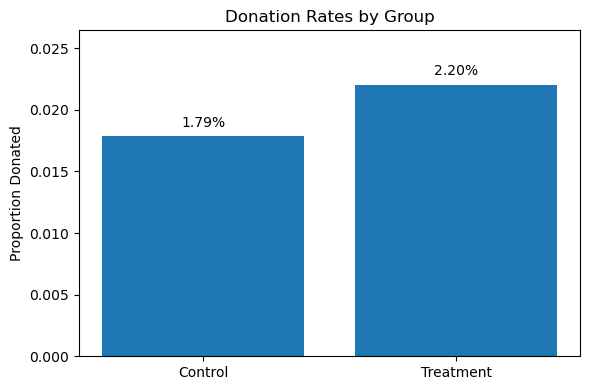

In [6]:
# Example proportions (replace with your actual values)
proportion_treatment = df[df['treatment'] == 1]['gave'].mean()
proportion_control = df[df['treatment'] == 0]['gave'].mean()

# Barplot setup
labels = ['Control', 'Treatment']
values = [proportion_control, proportion_treatment]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel('Proportion Donated')
plt.title('Donation Rates by Group')
plt.ylim(0, max(values)*1.2)

# Add percentage labels above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.0005, f"{v:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [7]:
# --- T-TEST: Difference in proportions for binary outcome 'gave' between treatment and control ---

# Separate treatment and control groups
gave_treatment = df[df['treatment'] == 1]['gave']
gave_control = df[df['treatment'] == 0]['gave']

# Calculate group means and sizes
p1 = gave_treatment.mean()
p2 = gave_control.mean()
n1 = gave_treatment.shape[0]
n2 = gave_control.shape[0]

# Calculate standard error and t-statistic
se = np.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
t_stat = (p1 - p2) / se

# Calculate degrees of freedom and p-value
df_ttest = n1 + n2 - 2
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df_ttest))

print("T-test results:")
print(f"  Treatment mean: {p1:.4f}")
print(f"  Control mean: {p2:.4f}")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}\n")


# --- LINEAR REGRESSION: gave ~ treatment ---

# Run regression
X = sm.add_constant(df['treatment'])
y = df['gave']
model = sm.OLS(y, X).fit()

print("Regression results:")
print(model.summary())


T-test results:
  Treatment mean: 0.0220
  Control mean: 0.0179
  T-statistic: 3.2095
  P-value: 0.0013

Regression results:
                            OLS Regression Results                            
Dep. Variable:                   gave   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.618
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00193
Time:                        15:12:52   Log-Likelihood:                 26630.
No. Observations:               50083   AIC:                        -5.326e+04
Df Residuals:                   50081   BIC:                        -5.324e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [8]:
import statsmodels.formula.api as smf

# Probit regression of 'gave' on 'treatment'
probit_model = smf.probit('gave ~ treatment', data=df).fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.100443
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                   gave   No. Observations:                50083
Model:                         Probit   Df Residuals:                    50081
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Apr 2025   Pseudo R-squ.:               0.0009783
Time:                        15:12:53   Log-Likelihood:                -5030.5
converged:                       True   LL-Null:                       -5035.4
Covariance Type:            nonrobust   LLR p-value:                  0.001696
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1001      0.023    -90.073      0.000      -2.146      -2.054
treatment      0.0868      0.

In [9]:
from scipy.stats import ttest_ind

# Subset groups based on match ratio
gave_ratio1 = df[df['ratio'] == 1]['gave']
gave_ratio2 = df[df['ratio'] == 2]['gave']
gave_ratio3 = df[df['ratio'] == 3]['gave']

# Perform independent t-tests
t_2v1, p_2v1 = ttest_ind(gave_ratio2, gave_ratio1, equal_var=False)
t_3v2, p_3v2 = ttest_ind(gave_ratio3, gave_ratio2, equal_var=False)
t_3v1, p_3v1 = ttest_ind(gave_ratio3, gave_ratio1, equal_var=False)

# Print results
print("T-Test Results (Donation Likelihood by Match Ratio):\n")
print(f"2:1 vs 1:1 -> t = {t_2v1:.3f}, p = {p_2v1:.4f}")
print(f"3:1 vs 2:1 -> t = {t_3v2:.3f}, p = {p_3v2:.4f}")
print(f"3:1 vs 1:1 -> t = {t_3v1:.3f}, p = {p_3v1:.4f}")


T-Test Results (Donation Likelihood by Match Ratio):

2:1 vs 1:1 -> t = 0.965, p = 0.3345
3:1 vs 2:1 -> t = 0.050, p = 0.9600
3:1 vs 1:1 -> t = 1.015, p = 0.3101


In [11]:
# Regress using 'ratio' as a categorical variable (automatically handles dummies)
cat_model = smf.ols('gave ~ C(ratio)', data=df).fit()

print("\nRegression with Categorical Variable:")
print(cat_model.summary())



Regression with Categorical Variable:
                            OLS Regression Results                            
Dep. Variable:                   gave   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.665
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0118
Time:                        15:33:53   Log-Likelihood:                 26630.
No. Observations:               50083   AIC:                        -5.325e+04
Df Residuals:                   50079   BIC:                        -5.322e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interce

In [12]:
import statsmodels.formula.api as smf

# --- RAW RESPONSE RATE DIFFERENCES ---
# Compute average donation rates by ratio level
response_rate_1to1 = df[df['ratio'] == 1]['gave'].mean()
response_rate_2to1 = df[df['ratio'] == 2]['gave'].mean()
response_rate_3to1 = df[df['ratio'] == 3]['gave'].mean()

# Calculate raw differences
raw_diff_2v1 = response_rate_2to1 - response_rate_1to1
raw_diff_3v2 = response_rate_3to1 - response_rate_2to1

print("Raw response rate differences:")
print(f"  2:1 vs 1:1: {raw_diff_2v1:.4f}")
print(f"  3:1 vs 2:1: {raw_diff_3v2:.4f}\n")

# --- REGRESSION APPROACH ---
# Create dummy variables if not already present
df['ratio2'] = (df['ratio'] == 2).astype(int)
df['ratio3'] = (df['ratio'] == 3).astype(int)

# Fit model using 1:1 as baseline
model = smf.ols('gave ~ ratio2 + ratio3', data=df).fit()

# Extract regression-based differences
reg_diff_2v1 = model.params['ratio2']
reg_diff_3v2 = model.params['ratio3'] - model.params['ratio2']

print("Regression-estimated response rate differences:")
print(f"  2:1 vs 1:1: {reg_diff_2v1:.4f}")
print(f"  3:1 vs 2:1: {reg_diff_3v2:.4f}")


Raw response rate differences:
  2:1 vs 1:1: 0.0019
  3:1 vs 2:1: 0.0001

Regression-estimated response rate differences:
  2:1 vs 1:1: 0.0036
  3:1 vs 2:1: 0.0001


In [13]:
### Size of Charitable Contribution

In [14]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# --- T-TEST ---
# Compare donation amounts between treatment and control groups
amount_treatment = df[df['treatment'] == 1]['amount']
amount_control = df[df['treatment'] == 0]['amount']

# T-test (unequal variance)
t_stat, p_val = ttest_ind(amount_treatment, amount_control, equal_var=False)

print("T-test: Donation Amount ~ Treatment")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  P-value: {p_val:.4f}\n")

# --- REGRESSION ---
# Run bivariate regression
model = smf.ols('amount ~ treatment', data=df).fit()

print("Bivariate Linear Regression: Donation Amount ~ Treatment")
print(model.summary())


T-test: Donation Amount ~ Treatment
  T-statistic: 1.918
  P-value: 0.0551

Bivariate Linear Regression: Donation Amount ~ Treatment
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.461
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0628
Time:                        15:37:20   Log-Likelihood:            -1.7946e+05
No. Observations:               50083   AIC:                         3.589e+05
Df Residuals:                   50081   BIC:                         3.589e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [15]:
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# --- FILTER: Only people who donated ---
df_donors = df[df['gave'] == 1]

# --- T-TEST on Amount Given ---
amount_treatment = df_donors[df_donors['treatment'] == 1]['amount']
amount_control = df_donors[df_donors['treatment'] == 0]['amount']

t_stat, p_val = ttest_ind(amount_treatment, amount_control, equal_var=False)

print("T-test (Amount Given | Gave = 1):")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  P-value: {p_val:.4f}\n")

# --- REGRESSION: Donation Amount ~ Treatment (only donors) ---
model = smf.ols('amount ~ treatment', data=df_donors).fit()

print("OLS Regression (Amount Given | Gave = 1):")
print(model.summary())


T-test (Amount Given | Gave = 1):
  T-statistic: -0.585
  P-value: 0.5590

OLS Regression (Amount Given | Gave = 1):
                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3374
Date:                Mon, 21 Apr 2025   Prob (F-statistic):              0.561
Time:                        15:37:43   Log-Likelihood:                -5326.8
No. Observations:                1034   AIC:                         1.066e+04
Df Residuals:                    1032   BIC:                         1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

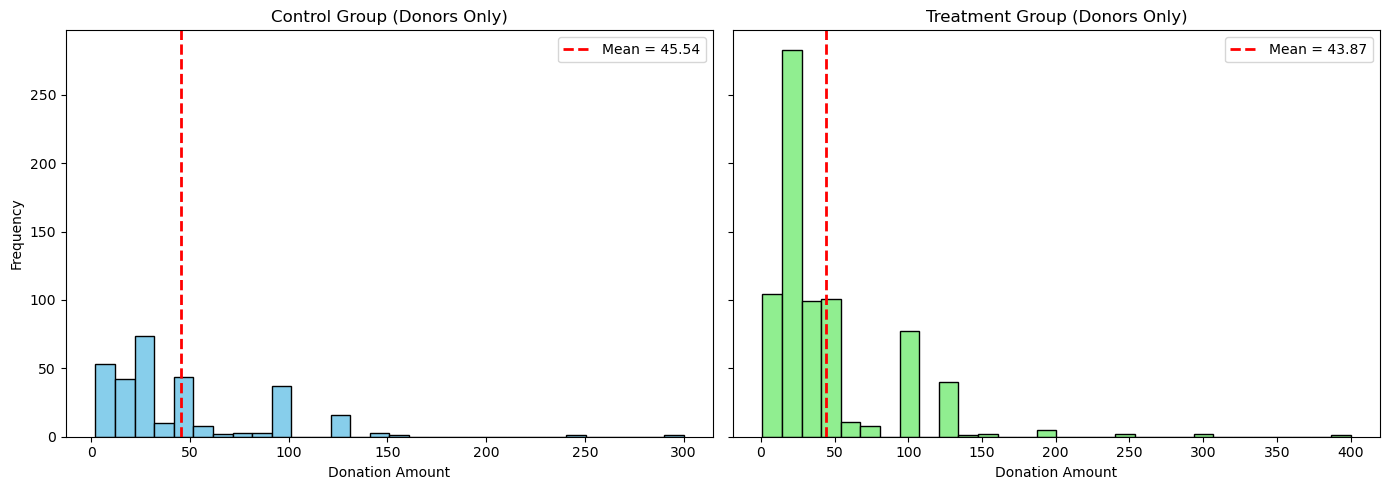

In [16]:
import matplotlib.pyplot as plt

# Filter to only people who donated
df_donors = df[df['gave'] == 1]

# Split into treatment and control
treatment_donors = df_donors[df_donors['treatment'] == 1]['amount']
control_donors = df_donors[df_donors['treatment'] == 0]['amount']

# Calculate means
mean_treatment = treatment_donors.mean()
mean_control = control_donors.mean()

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Control group plot
axes[0].hist(control_donors, bins=30, color='skyblue', edgecolor='black')
axes[0].axvline(mean_control, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_control:.2f}')
axes[0].set_title("Control Group (Donors Only)")
axes[0].set_xlabel("Donation Amount")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Treatment group plot
axes[1].hist(treatment_donors, bins=30, color='lightgreen', edgecolor='black')
axes[1].axvline(mean_treatment, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_treatment:.2f}')
axes[1].set_title("Treatment Group (Donors Only)")
axes[1].set_xlabel("Donation Amount")
axes[1].legend()

plt.tight_layout()
plt.show()


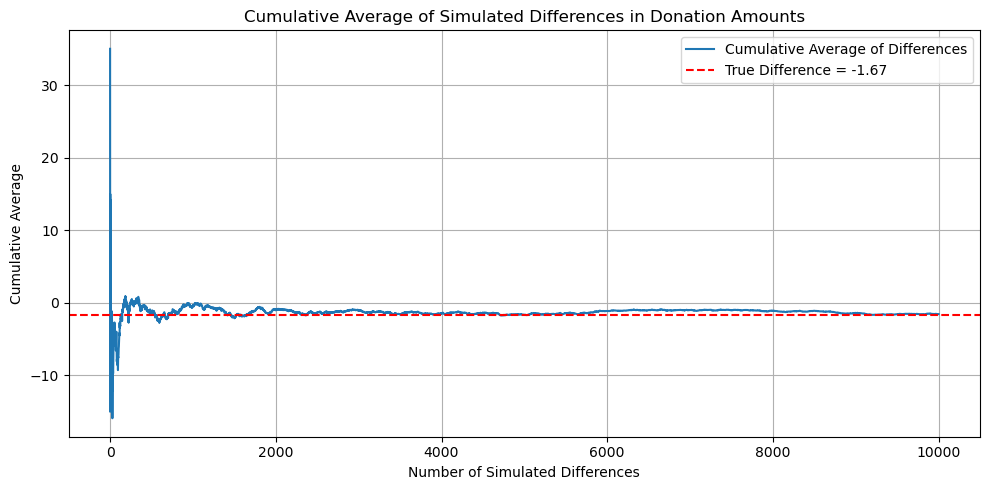

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Filter to only people who donated
df_donors = df[df['gave'] == 1]

# Control and treatment donation amounts
control = df_donors[df_donors['treatment'] == 0]['amount'].values
treatment = df_donors[df_donors['treatment'] == 1]['amount'].values

# True difference in means
true_diff = treatment.mean() - control.mean()

# Simulate draws
np.random.seed(42)
control_draws = np.random.choice(control, size=100000, replace=True)
treatment_draws = np.random.choice(treatment, size=10000, replace=True)

# Sample 10,000 control values from the 100,000 to match length
control_draws_subset = np.random.choice(control_draws, size=10000, replace=False)

# Calculate vector of differences
differences = treatment_draws - control_draws_subset

# Compute cumulative average
cumulative_avg = np.cumsum(differences) / np.arange(1, len(differences) + 1)

# Plot cumulative average
plt.figure(figsize=(10, 5))
plt.plot(cumulative_avg, label='Cumulative Average of Differences')
plt.axhline(true_diff, color='red', linestyle='--', label=f'True Difference = {true_diff:.2f}')
plt.title("Cumulative Average of Simulated Differences in Donation Amounts")
plt.xlabel("Number of Simulated Differences")
plt.ylabel("Cumulative Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


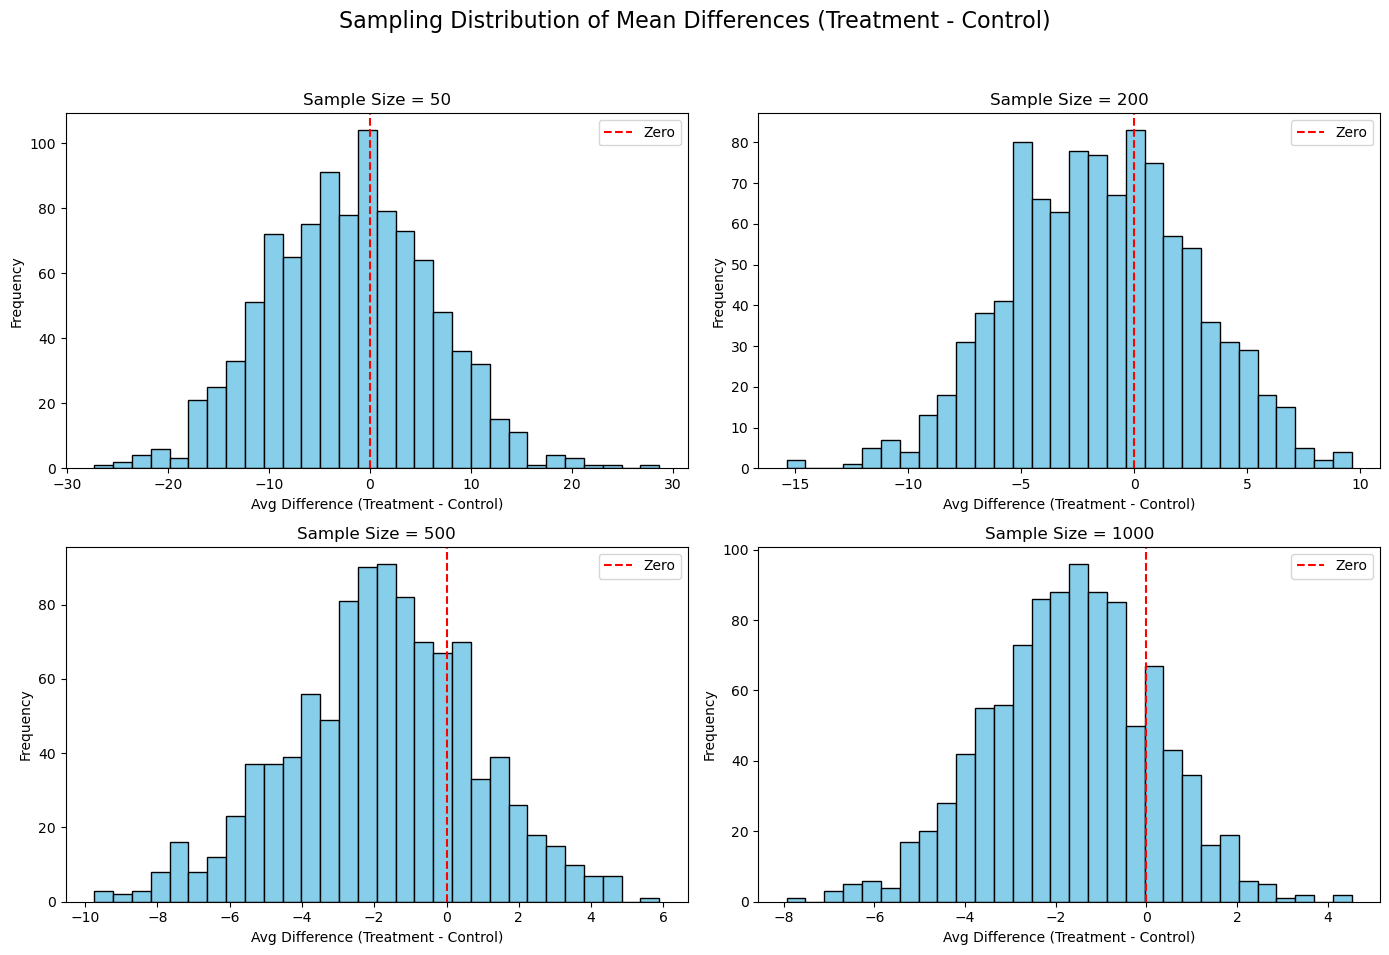

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Filter to only people who donated
df_donors = df[df['gave'] == 1]

# Extract treatment and control donation values
control = df_donors[df_donors['treatment'] == 0]['amount'].values
treatment = df_donors[df_donors['treatment'] == 1]['amount'].values

# Sample sizes and number of simulations
sample_sizes = [50, 200, 500, 1000]
num_simulations = 1000

# Setup 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

np.random.seed(42)

for i, n in enumerate(sample_sizes):
    avg_diffs = []
    for _ in range(num_simulations):
        control_sample = np.random.choice(control, size=n, replace=True)
        treatment_sample = np.random.choice(treatment, size=n, replace=True)
        avg_diffs.append(np.mean(treatment_sample) - np.mean(control_sample))
    
    ax = axes[i]
    ax.hist(avg_diffs, bins=30, color='skyblue', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.set_title(f"Sample Size = {n}")
    ax.set_xlabel("Avg Difference (Treatment - Control)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.suptitle("Sampling Distribution of Mean Differences (Treatment - Control)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
